In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import os

# Import Penrose modules
from penrose_tiling_fast import PenroseLatticeOptimized, analyze_overlapping_edges, plot_with_overlapping_analysis
from penrose_tight_binding import PenroseTightBinding

print("✓ All modules imported successfully!")
print(f"✓ Penrose Lattice (Fast Version) - Ready")
print(f"✓ Tight Binding Model - Ready")

✓ All modules imported successfully!
✓ Penrose Lattice (Fast Version) - Ready
✓ Tight Binding Model - Ready


# Animated Penrose Tiling Deflation

This section contains functions to visualize the step-by-step deflation process of the Penrose lattice, showing how each edge transforms during an iteration.

In [4]:
def animate_deflation_step_by_step(iteration_from=0, iteration_to=1, delay_seconds=2.0):
    """
    Animate the Penrose lattice deflation from one iteration to the next,
    showing each edge transformation step-by-step.
    
    Parameters:
    -----------
    iteration_from : int
        Starting iteration (default: 0)
    iteration_to : int
        Target iteration (default: 1)
    delay_seconds : float
        Delay between each edge deflation step (default: 2.0 seconds)
    """
    from IPython.display import clear_output, display
    import matplotlib.pyplot as plt
    
    phi = (1 + np.sqrt(5)) / 2
    phi_inv = 1 / phi
    
    print(f"Starting animation: Iteration {iteration_from} → {iteration_to}")
    print(f"Delay per edge: {delay_seconds} seconds\n")
    
    # Create initial lattice
    penrose = PenroseLatticeOptimized()
    penrose.create_seed_cluster()
    
    # Evolve to starting iteration
    for i in range(iteration_from):
        penrose.deflate_once()
    
    # Store initial state
    old_sources = np.array(penrose.edge_sources, dtype=np.int32)
    old_targets = np.array(penrose.edge_targets, dtype=np.int32)
    old_types = np.array(penrose.edge_types, dtype=np.int32)
    vertex_array = np.array(penrose.vertex_positions, dtype=np.float64)
    
    # Prepare for new iteration
    new_vertices = list(penrose.vertex_positions)
    new_vertex_hash = dict(penrose.vertex_hash)
    vertex_counter = penrose.vertex_counter
    new_edges_sources = []
    new_edges_targets = []
    new_edges_types = []
    
    def add_vertex_local(position):
        """Local vertex addition with deduplication"""
        nonlocal vertex_counter, new_vertices, new_vertex_hash
        
        hash_key = (int(np.round(position[0] * 1e8)), int(np.round(position[1] * 1e8)))
        
        if hash_key in new_vertex_hash:
            for vid in new_vertex_hash[hash_key]:
                if vid < len(new_vertices):
                    existing_pos = new_vertices[vid]
                    if np.linalg.norm(existing_pos - position) < 1e-9:
                        return vid
        
        vid = vertex_counter
        new_vertices.append(np.array(position, dtype=np.float64))
        
        if hash_key not in new_vertex_hash:
            new_vertex_hash[hash_key] = []
        new_vertex_hash[hash_key].append(vid)
        
        vertex_counter += 1
        return vid
    
    def deflate_single_arrow(pos_i, pos_j, i, j):
        """Deflate single arrow and return new edges"""
        vec_ij = pos_j - pos_i
        cos_72 = np.cos(np.deg2rad(72))
        sin_72 = np.sin(np.deg2rad(72))
        
        pos_k = pos_j - phi_inv * vec_ij
        vec_rot_neg = np.array([cos_72 * vec_ij[0] + sin_72 * vec_ij[1],
                                -sin_72 * vec_ij[0] + cos_72 * vec_ij[1]])
        pos_l = pos_i + phi_inv * vec_rot_neg
        vec_rot_pos = np.array([cos_72 * vec_ij[0] - sin_72 * vec_ij[1],
                                sin_72 * vec_ij[0] + cos_72 * vec_ij[1]])
        pos_m = pos_i + phi_inv * vec_rot_pos
        
        k = add_vertex_local(pos_k)
        l = add_vertex_local(pos_l)
        m = add_vertex_local(pos_m)
        
        return [(i, l, 2), (k, l, 1), (k, m, 1), (i, m, 2), (j, k, 2)]
    
    def deflate_double_arrow(pos_i, pos_j, i, j):
        """Deflate double arrow and return new edges"""
        vec_ij = pos_j - pos_i
        cos_36 = np.cos(np.deg2rad(36))
        sin_36 = np.sin(np.deg2rad(36))
        
        vec_rot_neg = np.array([cos_36 * vec_ij[0] + sin_36 * vec_ij[1],
                                -sin_36 * vec_ij[0] + cos_36 * vec_ij[1]])
        pos_g = pos_i + phi_inv * vec_rot_neg
        vec_rot_pos = np.array([cos_36 * vec_ij[0] - sin_36 * vec_ij[1],
                                sin_36 * vec_ij[0] + cos_36 * vec_ij[1]])
        pos_h = pos_i + phi_inv * vec_rot_pos
        
        g = add_vertex_local(pos_g)
        h = add_vertex_local(pos_h)
        
        return [(g, i, 1), (j, g, 2), (j, h, 2), (h, i, 1)]
    
    # Animate each edge deflation
    total_edges = len(old_sources)
    
    for edge_idx in range(total_edges):
        i = old_sources[edge_idx]
        j = old_targets[edge_idx]
        arrow_type = old_types[edge_idx]
        
        pos_i = vertex_array[i]
        pos_j = vertex_array[j]
        
        # Deflate current edge
        if arrow_type == 1:
            new_edges = deflate_single_arrow(pos_i, pos_j, i, j)
        else:
            new_edges = deflate_double_arrow(pos_i, pos_j, i, j)
        
        # Add to accumulator
        for vi, vj, atype in new_edges:
            new_edges_sources.append(vi)
            new_edges_targets.append(vj)
            new_edges_types.append(atype)
        
        # Plot current state
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
        
        # Left plot: Old iteration with highlighted current edge
        edge_type_name = 'Single Arrow' if arrow_type == 1 else 'Double Arrow'
        ax1.set_title(f'Iteration {iteration_from}', 
                     fontsize=14, fontweight='bold')
        
        # Plot all old edges with shaded lines to show the shape
        # Apply 18 degree clockwise rotation for visualization
        theta_rotation = -18.0  # negative = clockwise
        theta_rad = np.deg2rad(theta_rotation)
        cos_theta = np.cos(theta_rad)
        sin_theta = np.sin(theta_rad)
        
        for idx in range(len(old_sources)):
            # Get original positions
            x1_orig, y1_orig = vertex_array[old_sources[idx]]
            x2_orig, y2_orig = vertex_array[old_targets[idx]]
            
            # Apply rotation
            x1 = cos_theta * x1_orig - sin_theta * y1_orig
            y1 = sin_theta * x1_orig + cos_theta * y1_orig
            x2 = cos_theta * x2_orig - sin_theta * y2_orig
            y2 = sin_theta * x2_orig + cos_theta * y2_orig
            
            edge_color = 'blue' if old_types[idx] == 1 else 'red'
            
            # Draw shaded edge for all edges
            ax1.plot([x1, x2], [y1, y2], color=edge_color, linewidth=1.5, 
                    alpha=0.5, zorder=1, linestyle='-')
            
            if idx == edge_idx:
                # Highlight current edge with solid line and arrow
                ax1.plot([x1, x2], [y1, y2], color=edge_color, linewidth=3.5, 
                        alpha=1.0, zorder=3, linestyle='-')
                # Add arrow to show direction
                dx, dy = x2 - x1, y2 - y1
                ax1.arrow(x1 + 0.3*dx, y1 + 0.3*dy, 0.4*dx, 0.4*dy,
                         head_width=0.15, head_length=0.1, fc=edge_color, ec=edge_color, 
                         linewidth=2, zorder=5, alpha=1.0)
                ax1.scatter([x1, x2], [y1, y2], c=edge_color, s=100, zorder=4, 
                          edgecolors='white', linewidths=2)
        
        # Plot all old vertices (rotated)
        xs_old = [cos_theta * vertex_array[k][0] - sin_theta * vertex_array[k][1] 
                  for k in range(len(vertex_array))]
        ys_old = [sin_theta * vertex_array[k][0] + cos_theta * vertex_array[k][1] 
                  for k in range(len(vertex_array))]
        ax1.scatter(xs_old, ys_old, c='black', s=20, zorder=2, alpha=0.5)
        
        # Add legend for left plot
        from matplotlib.patches import FancyArrow
        from matplotlib.lines import Line2D
        legend_elements_left = [
            Line2D([0], [0], color='blue', linewidth=2.5, label='Single Arrow', 
                   marker='>', markersize=8, markerfacecolor='blue'),
            Line2D([0], [0], color='red', linewidth=2.5, label='Double Arrow', 
                   marker='>', markersize=8, markerfacecolor='red')
        ]
        ax1.legend(handles=legend_elements_left, loc='upper right', fontsize=10, framealpha=0.9)
        
        ax1.set_aspect('equal')
        ax1.grid(True, alpha=0.2)
        ax1.set_xlabel('x', fontsize=11)
        ax1.set_ylabel('y', fontsize=11)
        
        # Right plot: New iteration (scaled)
        ax2.set_title(f'Iteration {iteration_to}', 
                     fontsize=14, fontweight='bold')
        
        # Scale vertices by phi for next iteration and apply same rotation
        scaled_vertices = [v * phi for v in new_vertices]
        
        # Plot new edges with arrows (with rotation)
        for idx in range(len(new_edges_sources)):
            vi = new_edges_sources[idx]
            vj = new_edges_targets[idx]
            atype = new_edges_types[idx]
            
            if vi < len(scaled_vertices) and vj < len(scaled_vertices):
                # Get original scaled positions
                x1_orig, y1_orig = scaled_vertices[vi]
                x2_orig, y2_orig = scaled_vertices[vj]
                
                # Apply same rotation as iteration 0
                x1 = cos_theta * x1_orig - sin_theta * y1_orig
                y1 = sin_theta * x1_orig + cos_theta * y1_orig
                x2 = cos_theta * x2_orig - sin_theta * y2_orig
                y2 = sin_theta * x2_orig + cos_theta * y2_orig
                
                color = 'blue' if atype == 1 else 'red'
                # Make newly added edges more visible
                alpha = 1.0 if idx >= len(new_edges_sources) - len(new_edges) else 0.9
                linewidth = 2.5 if idx >= len(new_edges_sources) - len(new_edges) else 1.0
                ax2.plot([x1, x2], [y1, y2], color=color, linewidth=linewidth, alpha=alpha, zorder=1)
                
                # Add arrows for newly added edges
                if idx >= len(new_edges_sources) - len(new_edges):
                    dx, dy = x2 - x1, y2 - y1
                    length = np.sqrt(dx**2 + dy**2)
                    if length > 0:
                        ax2.arrow(x1 + 0.35*dx, y1 + 0.35*dy, 0.3*dx, 0.3*dy,
                                 head_width=0.15, head_length=0.1, fc=color, ec=color,
                                 linewidth=1.5, zorder=3, alpha=1.0)
        
        # Plot new vertices (rotated)
        xs_new = [cos_theta * scaled_vertices[k][0] - sin_theta * scaled_vertices[k][1] 
                  for k in range(len(scaled_vertices))]
        ys_new = [sin_theta * scaled_vertices[k][0] + cos_theta * scaled_vertices[k][1] 
                  for k in range(len(scaled_vertices))]
        ax2.scatter(xs_new, ys_new, c='black', s=20, zorder=2, alpha=0.7, edgecolors='white', linewidths=0.5)
        
        # Add legend for right plot
        legend_elements_right = [
            Line2D([0], [0], color='blue', linewidth=2.5, label='Single Arrow', 
                   marker='>', markersize=8, markerfacecolor='blue'),
            Line2D([0], [0], color='red', linewidth=2.5, label='Double Arrow', 
                   marker='>', markersize=8, markerfacecolor='red')
        ]
        ax2.legend(handles=legend_elements_right, loc='upper right', fontsize=10, framealpha=0.9)
        
        ax2.set_aspect('equal')
        ax2.grid(True, alpha=0.2)
        ax2.set_xlabel('x', fontsize=11)
        ax2.set_ylabel('y', fontsize=11)
        
        # Match axis limits
        if len(xs_old) > 0:
            max_coord = max(max(abs(x) for x in xs_old), max(abs(y) for y in ys_old))
            margin = max_coord * 0.15
            ax1.set_xlim(-max_coord - margin, max_coord + margin)
            ax1.set_ylim(-max_coord - margin, max_coord + margin)
        
        if len(xs_new) > 0:
            max_coord = max(max(abs(x) for x in xs_new), max(abs(y) for y in ys_new))
            margin = max_coord * 0.15
            ax2.set_xlim(-max_coord - margin, max_coord + margin)
            ax2.set_ylim(-max_coord - margin, max_coord + margin)
        
        plt.tight_layout()
        
        # Display and wait
        clear_output(wait=True)
        display(fig)
        plt.close()
        
        time.sleep(delay_seconds)
    
    print(f"\n✅ Animation complete!")
    print(f"   Iteration {iteration_from}: {len(old_sources)} edges")
    print(f"   Iteration {iteration_to}: {len(new_edges_sources)} edges")


## Run the Animation

Execute the cell below to see the step-by-step deflation animation. Each edge from iteration 0 will be transformed with a 2-second delay between steps.

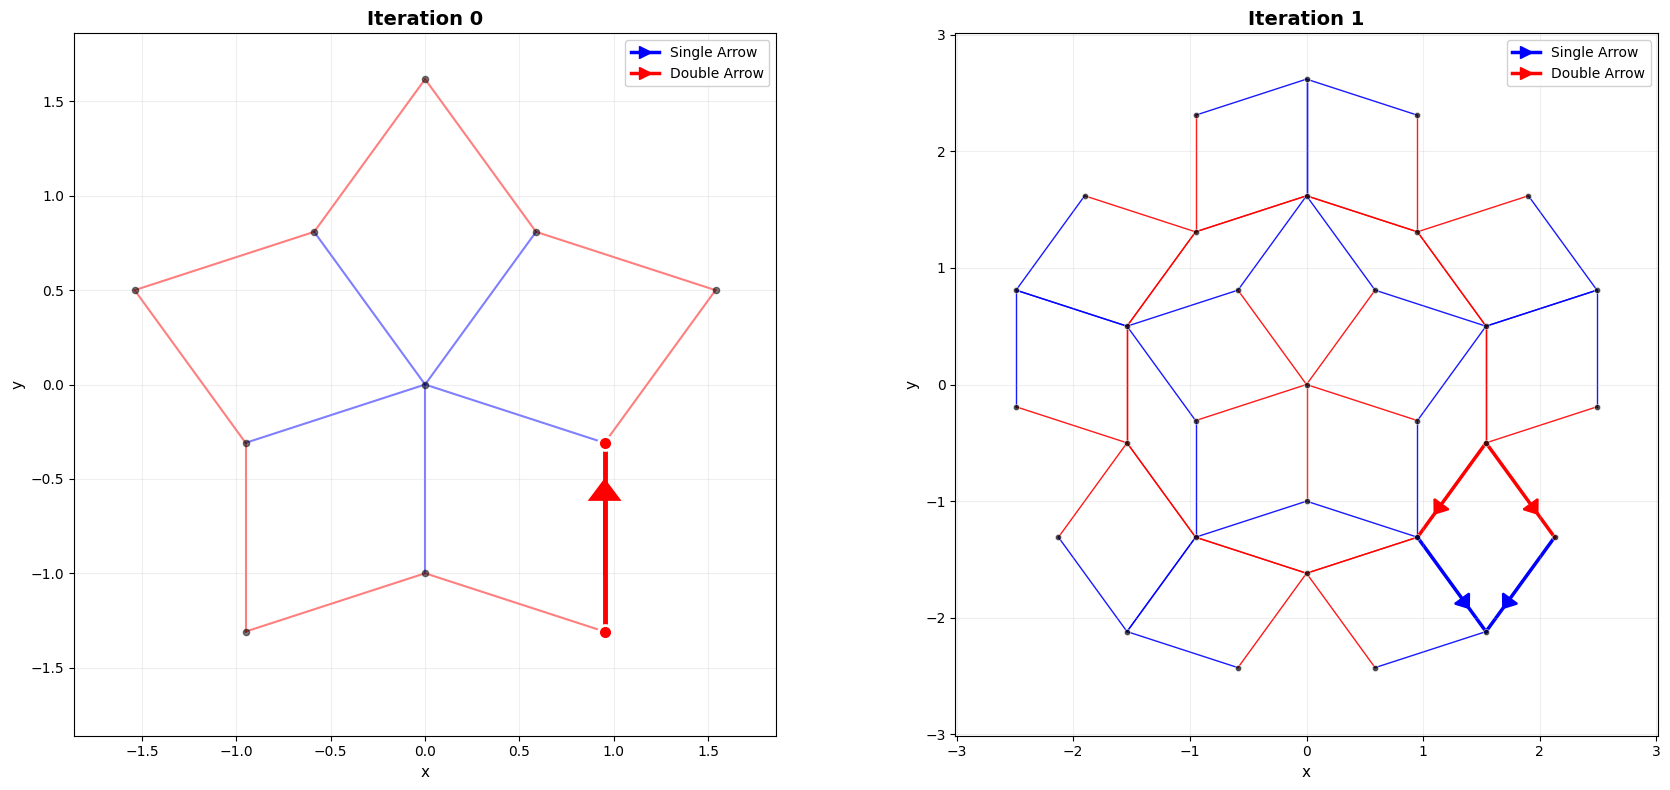


✅ Animation complete!
   Iteration 0: 15 edges
   Iteration 1: 65 edges


In [5]:
# Run animation: Iteration 0 → 1 with 2 second delay per edge
# Note: This will take time! (25 edges × 2 seconds = ~50 seconds total)
animate_deflation_step_by_step(iteration_from=0, iteration_to=1, delay_seconds=0.5)

## Faster Animation (Optional)

If you want to see the animation faster, you can reduce the delay time:

In [6]:
# Faster animation with 0.5 second delay
# animate_deflation_step_by_step(iteration_from=0, iteration_to=1, delay_seconds=0.5)

# Or animate from iteration 1 to 2 (more edges, will take longer!)
# animate_deflation_step_by_step(iteration_from=1, iteration_to=2, delay_seconds=1.0)

# BFS Bipartite Coloring Animation

Visualize how Breadth-First Search (BFS) assigns vertices to sublattices A (red) and B (blue) in the Penrose lattice.

In [7]:
def animate_bfs_coloring(iteration=1, delay_seconds=0.5):
    """
    Animate BFS bipartite coloring of the Penrose lattice.
    Shows step-by-step how vertices are assigned to sublattices A and B.
    
    Parameters:
    -----------
    iteration : int
        Which iteration to use (default: 1)
    delay_seconds : float
        Delay between each vertex coloring step (default: 0.5 seconds)
    """
    from IPython.display import clear_output, display
    from collections import deque
    import matplotlib.pyplot as plt
    
    print(f"Starting BFS coloring animation for Iteration {iteration}")
    print(f"Delay per vertex: {delay_seconds} seconds\n")
    
    # Create lattice
    penrose = PenroseLatticeOptimized()
    penrose.create_seed_cluster()
    
    # Evolve to target iteration
    for i in range(iteration):
        penrose.deflate_once()
    
    # Get data
    N = len(penrose.vertex_positions)
    vertex_positions = np.array(penrose.vertex_positions, dtype=np.float64)
    
    # Build adjacency list (undirected)
    adjacency = {i: set() for i in range(N)}
    for idx in range(len(penrose.edge_sources)):
        i = penrose.edge_sources[idx]
        j = penrose.edge_targets[idx]
        adjacency[i].add(j)
        adjacency[j].add(i)
    
    # Apply rotation for visualization
    phi = (1 + np.sqrt(5)) / 2
    theta_rotation = -18.0
    theta_rad = np.deg2rad(theta_rotation)
    cos_theta = np.cos(theta_rad)
    sin_theta = np.sin(theta_rad)
    
    # Scale and rotate vertices
    scaled_rotated_positions = []
    for pos in vertex_positions:
        scaled = pos * phi
        x_rot = cos_theta * scaled[0] - sin_theta * scaled[1]
        y_rot = sin_theta * scaled[0] + cos_theta * scaled[1]
        scaled_rotated_positions.append([x_rot, y_rot])
    scaled_rotated_positions = np.array(scaled_rotated_positions)
    
    # BFS coloring state
    sublattice_map = {}  # vertex_id -> 'A' or 'B'
    visited_order = []  # Track order of visits
    
    # BFS queue
    queue = deque()
    start_node = 0
    sublattice_map[start_node] = 'A'
    queue.append(start_node)
    visited_order.append((start_node, 'A'))
    
    # Animate BFS process
    step = 0
    
    while queue:
        # Get current vertex
        u = queue.popleft()
        label_u = sublattice_map[u]
        opposite_label = 'B' if label_u == 'A' else 'A'
        
        # Get neighbors that need to be colored
        neighbors_to_color = []
        for v in adjacency[u]:
            if v not in sublattice_map:
                sublattice_map[v] = opposite_label
                queue.append(v)
                neighbors_to_color.append(v)
                visited_order.append((v, opposite_label))
        
        # Visualize current state
        if neighbors_to_color or step == 0:  # Show initial state and when coloring happens
            fig, ax = plt.subplots(1, 1, figsize=(12, 12))
            
            ax.set_title(f'BFS Bipartite Coloring - Iteration {iteration}\nStep {step + 1}: Colored {len(sublattice_map)}/{N} vertices', 
                        fontsize=14, fontweight='bold')
            
            # Plot all edges (more visible)
            for idx in range(len(penrose.edge_sources)):
                i = penrose.edge_sources[idx]
                j = penrose.edge_targets[idx]
                x1, y1 = scaled_rotated_positions[i]
                x2, y2 = scaled_rotated_positions[j]
                ax.plot([x1, x2], [y1, y2], color='black', linewidth=1.2, alpha=0.5, zorder=1)
            
            # Plot vertices by color state
            uncolored_vertices = []
            sublattice_a_vertices = []
            sublattice_b_vertices = []
            current_vertex = []
            newly_colored = []
            
            for vid in range(N):
                if vid == u:
                    current_vertex.append(vid)
                elif vid in neighbors_to_color:
                    newly_colored.append(vid)
                elif vid in sublattice_map:
                    if sublattice_map[vid] == 'A':
                        sublattice_a_vertices.append(vid)
                    else:
                        sublattice_b_vertices.append(vid)
                else:
                    uncolored_vertices.append(vid)
            
            # Plot uncolored (gray)
            if uncolored_vertices:
                xs = [scaled_rotated_positions[v][0] for v in uncolored_vertices]
                ys = [scaled_rotated_positions[v][1] for v in uncolored_vertices]
                ax.scatter(xs, ys, c='lightgray', s=50, zorder=2, alpha=0.4, edgecolors='gray', linewidths=0.5)
            
            # Plot sublattice A (red)
            if sublattice_a_vertices:
                xs = [scaled_rotated_positions[v][0] for v in sublattice_a_vertices]
                ys = [scaled_rotated_positions[v][1] for v in sublattice_a_vertices]
                ax.scatter(xs, ys, c='red', s=80, zorder=3, alpha=0.8, edgecolors='darkred', linewidths=1)
            
            # Plot sublattice B (blue)
            if sublattice_b_vertices:
                xs = [scaled_rotated_positions[v][0] for v in sublattice_b_vertices]
                ys = [scaled_rotated_positions[v][1] for v in sublattice_b_vertices]
                ax.scatter(xs, ys, c='blue', s=80, zorder=3, alpha=0.8, edgecolors='darkblue', linewidths=1)
            
            # Plot current vertex being processed (yellow with black edge)
            if current_vertex:
                xs = [scaled_rotated_positions[v][0] for v in current_vertex]
                ys = [scaled_rotated_positions[v][1] for v in current_vertex]
                ax.scatter(xs, ys, c='yellow', s=150, zorder=5, alpha=1.0, edgecolors='black', linewidths=2.5)
            
            # Plot newly colored vertices (green)
            if newly_colored:
                xs = [scaled_rotated_positions[v][0] for v in newly_colored]
                ys = [scaled_rotated_positions[v][1] for v in newly_colored]
                ax.scatter(xs, ys, c='lime', s=120, zorder=4, alpha=1.0, edgecolors='darkgreen', linewidths=2)
            
            # Legend
            from matplotlib.lines import Line2D
            legend_elements = [
                Line2D([0], [0], marker='o', color='w', label='Sublattice A', 
                       markerfacecolor='red', markersize=10, markeredgecolor='darkred', markeredgewidth=1),
                Line2D([0], [0], marker='o', color='w', label='Sublattice B', 
                       markerfacecolor='blue', markersize=10, markeredgecolor='darkblue', markeredgewidth=1),
                Line2D([0], [0], marker='o', color='w', label='Current vertex', 
                       markerfacecolor='yellow', markersize=10, markeredgecolor='black', markeredgewidth=1.5),
                Line2D([0], [0], marker='o', color='w', label='Newly colored', 
                       markerfacecolor='lime', markersize=10, markeredgecolor='darkgreen', markeredgewidth=1.5),
                Line2D([0], [0], marker='o', color='w', label='Uncolored', 
                       markerfacecolor='lightgray', markersize=10, markeredgecolor='gray', markeredgewidth=0.5)
            ]
            ax.legend(handles=legend_elements, loc='upper right', fontsize=11, framealpha=0.95)
            
            ax.set_aspect('equal')
            ax.grid(True, alpha=0.2)
            ax.set_xlabel('x', fontsize=11)
            ax.set_ylabel('y', fontsize=11)
            
            # Set axis limits
            max_coord = max(max(abs(x) for x in scaled_rotated_positions[:, 0]), 
                           max(abs(y) for y in scaled_rotated_positions[:, 1]))
            margin = max_coord * 0.15
            ax.set_xlim(-max_coord - margin, max_coord + margin)
            ax.set_ylim(-max_coord - margin, max_coord + margin)
            
            plt.tight_layout()
            
            # Display and wait
            clear_output(wait=True)
            display(fig)
            plt.close()
            
            time.sleep(delay_seconds)
            step += 1
    
    # Final visualization
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    
    ax.set_title(f'BFS Bipartite Coloring - Iteration {iteration}\nFinal Result: All {N} vertices colored', 
                fontsize=14, fontweight='bold')
    
    # Plot all edges
    for idx in range(len(penrose.edge_sources)):
        i = penrose.edge_sources[idx]
        j = penrose.edge_targets[idx]
        x1, y1 = scaled_rotated_positions[i]
        x2, y2 = scaled_rotated_positions[j]
        ax.plot([x1, x2], [y1, y2], color='black', linewidth=1.2, alpha=0.5, zorder=1)
    
    # Plot final colored vertices
    sublattice_a_vertices = [v for v in range(N) if sublattice_map[v] == 'A']
    sublattice_b_vertices = [v for v in range(N) if sublattice_map[v] == 'B']
    
    xs_a = [scaled_rotated_positions[v][0] for v in sublattice_a_vertices]
    ys_a = [scaled_rotated_positions[v][1] for v in sublattice_a_vertices]
    ax.scatter(xs_a, ys_a, c='red', s=80, zorder=3, alpha=0.8, edgecolors='darkred', linewidths=1)
    
    xs_b = [scaled_rotated_positions[v][0] for v in sublattice_b_vertices]
    ys_b = [scaled_rotated_positions[v][1] for v in sublattice_b_vertices]
    ax.scatter(xs_b, ys_b, c='blue', s=80, zorder=3, alpha=0.8, edgecolors='darkblue', linewidths=1)
    
    # Legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=f'Sublattice A ({len(sublattice_a_vertices)} vertices)', 
               markerfacecolor='red', markersize=10, markeredgecolor='darkred', markeredgewidth=1),
        Line2D([0], [0], marker='o', color='w', label=f'Sublattice B ({len(sublattice_b_vertices)} vertices)', 
               markerfacecolor='blue', markersize=10, markeredgecolor='darkblue', markeredgewidth=1)
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=11, framealpha=0.95)
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.2)
    ax.set_xlabel('x', fontsize=11)
    ax.set_ylabel('y', fontsize=11)
    
    max_coord = max(max(abs(x) for x in scaled_rotated_positions[:, 0]), 
                   max(abs(y) for y in scaled_rotated_positions[:, 1]))
    margin = max_coord * 0.15
    ax.set_xlim(-max_coord - margin, max_coord + margin)
    ax.set_ylim(-max_coord - margin, max_coord + margin)
    
    plt.tight_layout()
    clear_output(wait=True)
    display(fig)
    plt.close()
    
    print(f"\n✅ BFS coloring complete!")
    print(f"   Sublattice A (red): {len(sublattice_a_vertices)} vertices")
    print(f"   Sublattice B (blue): {len(sublattice_b_vertices)} vertices")
    print(f"   Total steps: {step}")

print("✓ Function 'animate_bfs_coloring' created!")

✓ Function 'animate_bfs_coloring' created!


## Run BFS Coloring Animation

Execute the cell below to see how BFS assigns vertices to sublattices A (red) and B (blue).

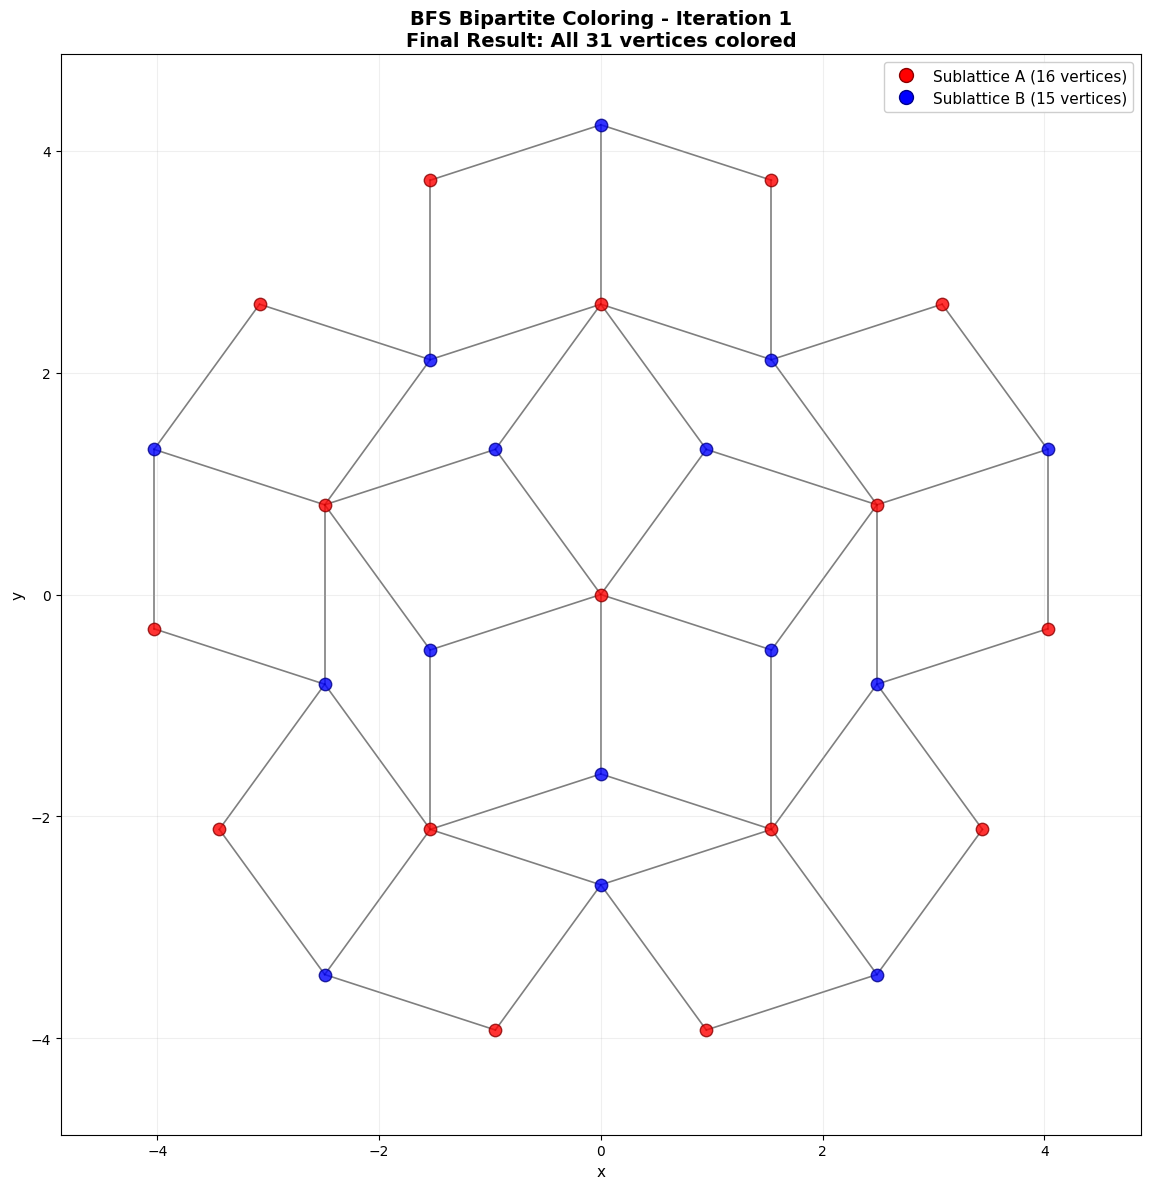


✅ BFS coloring complete!
   Sublattice A (red): 16 vertices
   Sublattice B (blue): 15 vertices
   Total steps: 15


In [8]:
# Run BFS coloring animation on iteration 1
# The animation shows:
# - Yellow vertex: currently being processed
# - Green vertices: newly colored neighbors
# - Red vertices: Sublattice A
# - Blue vertices: Sublattice B
# - Gray vertices: not yet colored

animate_bfs_coloring(iteration=1, delay_seconds=3.0)





































































































































































































































































































































# Save Animations as GIF

Create GIF files from the animations for easy sharing and documentation.

In [9]:
def save_deflation_animation_as_gif(iteration_from=0, iteration_to=1, 
                                     filename='penrose_deflation.gif', 
                                     duration=1000, max_frames=30):
    """
    Save deflation animation as GIF file.
    
    Parameters:
    -----------
    iteration_from : int
        Starting iteration (default: 0)
    iteration_to : int
        Target iteration (default: 1)
    filename : str
        Output filename (default: 'penrose_deflation.gif')
    duration : int
        Duration per frame in milliseconds (default: 1000 = 1 second)
    max_frames : int
        Maximum number of frames to save (default: 30)
    """
    import matplotlib.pyplot as plt
    from PIL import Image
    import io
    
    print(f"🎬 Creating deflation animation GIF: {filename}")
    print(f"   Iteration {iteration_from} → {iteration_to}")
    print(f"   Duration per frame: {duration}ms")
    print()
    
    phi = (1 + np.sqrt(5)) / 2
    phi_inv = 1 / phi
    
    # Create lattice
    penrose = PenroseLatticeOptimized()
    penrose.create_seed_cluster()
    
    for i in range(iteration_from):
        penrose.deflate_once()
    
    # Store initial state
    old_sources = np.array(penrose.edge_sources, dtype=np.int32)
    old_targets = np.array(penrose.edge_targets, dtype=np.int32)
    old_types = np.array(penrose.edge_types, dtype=np.int32)
    vertex_array = np.array(penrose.vertex_positions, dtype=np.float64)
    
    # Prepare for new iteration
    new_vertices = list(penrose.vertex_positions)
    new_vertex_hash = dict(penrose.vertex_hash)
    vertex_counter = penrose.vertex_counter
    new_edges_sources = []
    new_edges_targets = []
    new_edges_types = []
    
    def add_vertex_local(position):
        nonlocal vertex_counter, new_vertices, new_vertex_hash
        hash_key = (int(np.round(position[0] * 1e8)), int(np.round(position[1] * 1e8)))
        if hash_key in new_vertex_hash:
            for vid in new_vertex_hash[hash_key]:
                if vid < len(new_vertices):
                    if np.linalg.norm(new_vertices[vid] - position) < 1e-9:
                        return vid
        vid = vertex_counter
        new_vertices.append(np.array(position, dtype=np.float64))
        if hash_key not in new_vertex_hash:
            new_vertex_hash[hash_key] = []
        new_vertex_hash[hash_key].append(vid)
        vertex_counter += 1
        return vid
    
    def deflate_single_arrow(pos_i, pos_j, i, j):
        vec_ij = pos_j - pos_i
        cos_72, sin_72 = np.cos(np.deg2rad(72)), np.sin(np.deg2rad(72))
        pos_k = pos_j - phi_inv * vec_ij
        vec_rot_neg = np.array([cos_72 * vec_ij[0] + sin_72 * vec_ij[1],
                                -sin_72 * vec_ij[0] + cos_72 * vec_ij[1]])
        pos_l = pos_i + phi_inv * vec_rot_neg
        vec_rot_pos = np.array([cos_72 * vec_ij[0] - sin_72 * vec_ij[1],
                                sin_72 * vec_ij[0] + cos_72 * vec_ij[1]])
        pos_m = pos_i + phi_inv * vec_rot_pos
        k, l, m = add_vertex_local(pos_k), add_vertex_local(pos_l), add_vertex_local(pos_m)
        return [(i, l, 2), (k, l, 1), (k, m, 1), (i, m, 2), (j, k, 2)]
    
    def deflate_double_arrow(pos_i, pos_j, i, j):
        vec_ij = pos_j - pos_i
        cos_36, sin_36 = np.cos(np.deg2rad(36)), np.sin(np.deg2rad(36))
        vec_rot_neg = np.array([cos_36 * vec_ij[0] + sin_36 * vec_ij[1],
                                -sin_36 * vec_ij[0] + cos_36 * vec_ij[1]])
        pos_g = pos_i + phi_inv * vec_rot_neg
        vec_rot_pos = np.array([cos_36 * vec_ij[0] - sin_36 * vec_ij[1],
                                sin_36 * vec_ij[0] + cos_36 * vec_ij[1]])
        pos_h = pos_i + phi_inv * vec_rot_pos
        g, h = add_vertex_local(pos_g), add_vertex_local(pos_h)
        return [(g, i, 1), (j, g, 2), (j, h, 2), (h, i, 1)]
    
    # Rotation parameters
    theta_rad = np.deg2rad(-18.0)
    cos_theta, sin_theta = np.cos(theta_rad), np.sin(theta_rad)
    
    # Collect frames
    frames = []
    total_edges = len(old_sources)
    step_size = max(1, total_edges // max_frames)
    
    print(f"   Generating frames (sampling every {step_size} edges)...")
    
    for edge_idx in range(total_edges):
        i, j = old_sources[edge_idx], old_targets[edge_idx]
        arrow_type = old_types[edge_idx]
        
        # Deflate
        if arrow_type == 1:
            new_edges = deflate_single_arrow(vertex_array[i], vertex_array[j], i, j)
        else:
            new_edges = deflate_double_arrow(vertex_array[i], vertex_array[j], i, j)
        
        for vi, vj, atype in new_edges:
            new_edges_sources.append(vi)
            new_edges_targets.append(vj)
            new_edges_types.append(atype)
        
        # Sample frames
        if edge_idx % step_size == 0 or edge_idx == total_edges - 1:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
            
            # Left: Iteration 0
            ax1.set_title(f'Iteration {iteration_from}', fontsize=14, fontweight='bold')
            for idx in range(len(old_sources)):
                x1, y1 = vertex_array[old_sources[idx]]
                x2, y2 = vertex_array[old_targets[idx]]
                x1, y1 = cos_theta * x1 - sin_theta * y1, sin_theta * x1 + cos_theta * y1
                x2, y2 = cos_theta * x2 - sin_theta * y2, sin_theta * x2 + cos_theta * y2
                color = 'blue' if old_types[idx] == 1 else 'red'
                alpha = 1.0 if idx == edge_idx else 0.5
                lw = 3.5 if idx == edge_idx else 1.5
                ax1.plot([x1, x2], [y1, y2], color=color, linewidth=lw, alpha=alpha, zorder=1)
            
            xs_old = [cos_theta * vertex_array[k][0] - sin_theta * vertex_array[k][1] for k in range(len(vertex_array))]
            ys_old = [sin_theta * vertex_array[k][0] + cos_theta * vertex_array[k][1] for k in range(len(vertex_array))]
            ax1.scatter(xs_old, ys_old, c='black', s=15, zorder=2, alpha=0.5)
            ax1.set_aspect('equal')
            ax1.grid(True, alpha=0.2)
            
            # Right: Iteration 1
            ax2.set_title(f'Iteration {iteration_to}', fontsize=14, fontweight='bold')
            scaled_vertices = [v * phi for v in new_vertices]
            for idx in range(len(new_edges_sources)):
                vi, vj = new_edges_sources[idx], new_edges_targets[idx]
                if vi < len(scaled_vertices) and vj < len(scaled_vertices):
                    x1, y1 = scaled_vertices[vi]
                    x2, y2 = scaled_vertices[vj]
                    x1, y1 = cos_theta * x1 - sin_theta * y1, sin_theta * x1 + cos_theta * y1
                    x2, y2 = cos_theta * x2 - sin_theta * y2, sin_theta * x2 + cos_theta * y2
                    color = 'blue' if new_edges_types[idx] == 1 else 'red'
                    alpha = 1.0 if idx >= len(new_edges_sources) - len(new_edges) else 0.7
                    lw = 2.0 if idx >= len(new_edges_sources) - len(new_edges) else 0.8
                    ax2.plot([x1, x2], [y1, y2], color=color, linewidth=lw, alpha=alpha, zorder=1)
            
            xs_new = [cos_theta * scaled_vertices[k][0] - sin_theta * scaled_vertices[k][1] for k in range(len(scaled_vertices))]
            ys_new = [sin_theta * scaled_vertices[k][0] + cos_theta * scaled_vertices[k][1] for k in range(len(scaled_vertices))]
            ax2.scatter(xs_new, ys_new, c='black', s=15, zorder=2, alpha=0.6)
            ax2.set_aspect('equal')
            ax2.grid(True, alpha=0.2)
            
            plt.tight_layout()
            
            # Save frame to buffer
            buf = io.BytesIO()
            plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
            buf.seek(0)
            frames.append(Image.open(buf))
            plt.close()
            
            print(f"     Frame {len(frames)}/{max_frames}: Edge {edge_idx+1}/{total_edges}")
    
    # Save as GIF
    print(f"\n   Saving GIF...")
    frames[0].save(filename, save_all=True, append_images=frames[1:], 
                   duration=duration, loop=0, optimize=False)
    
    print(f"\n✅ GIF saved: {filename}")
    print(f"   Total frames: {len(frames)}")
    print(f"   File size: {os.path.getsize(filename) / 1024:.1f} KB")

print("✓ Function 'save_deflation_animation_as_gif' created!")

✓ Function 'save_deflation_animation_as_gif' created!


In [10]:
def save_bfs_coloring_as_gif(iteration=1, filename='penrose_bfs_coloring.gif', 
                              duration=500, max_frames=50):
    """
    Save BFS coloring animation as GIF file.
    
    Parameters:
    -----------
    iteration : int
        Which iteration to use (default: 1)
    filename : str
        Output filename (default: 'penrose_bfs_coloring.gif')
    duration : int
        Duration per frame in milliseconds (default: 500 = 0.5 second)
    max_frames : int
        Maximum number of frames (default: 50)
    """
    from collections import deque
    import matplotlib.pyplot as plt
    from PIL import Image
    import io
    
    print(f"🎬 Creating BFS coloring animation GIF: {filename}")
    print(f"   Iteration: {iteration}")
    print(f"   Duration per frame: {duration}ms")
    print()
    
    # Create lattice
    penrose = PenroseLatticeOptimized()
    penrose.create_seed_cluster()
    
    for i in range(iteration):
        penrose.deflate_once()
    
    N = len(penrose.vertex_positions)
    vertex_positions = np.array(penrose.vertex_positions, dtype=np.float64)
    
    # Build adjacency
    adjacency = {i: set() for i in range(N)}
    for idx in range(len(penrose.edge_sources)):
        i, j = penrose.edge_sources[idx], penrose.edge_targets[idx]
        adjacency[i].add(j)
        adjacency[j].add(i)
    
    # Rotation and scaling
    phi = (1 + np.sqrt(5)) / 2
    theta_rad = np.deg2rad(-18.0)
    cos_theta, sin_theta = np.cos(theta_rad), np.sin(theta_rad)
    
    positions = []
    for pos in vertex_positions:
        scaled = pos * phi
        x = cos_theta * scaled[0] - sin_theta * scaled[1]
        y = sin_theta * scaled[0] + cos_theta * scaled[1]
        positions.append([x, y])
    positions = np.array(positions)
    
    # Run BFS and collect states
    sublattice_map = {}
    queue = deque([0])
    sublattice_map[0] = 'A'
    
    states = []
    step = 0
    
    # Initial state
    states.append({
        'current': 0,
        'newly_colored': [],
        'sublattice_map': dict(sublattice_map),
        'step': step
    })
    
    while queue:
        u = queue.popleft()
        label_u = sublattice_map[u]
        opposite = 'B' if label_u == 'A' else 'A'
        
        neighbors_to_color = []
        for v in adjacency[u]:
            if v not in sublattice_map:
                sublattice_map[v] = opposite
                queue.append(v)
                neighbors_to_color.append(v)
        
        if neighbors_to_color:
            step += 1
            states.append({
                'current': u,
                'newly_colored': neighbors_to_color[:],
                'sublattice_map': dict(sublattice_map),
                'step': step
            })
    
    # Sample states
    step_size = max(1, len(states) // max_frames)
    sampled_states = [states[i] for i in range(0, len(states), step_size)]
    if states[-1] not in sampled_states:
        sampled_states.append(states[-1])
    
    print(f"   Generating frames ({len(sampled_states)} frames)...")
    
    frames = []
    for state_idx, state in enumerate(sampled_states):
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
        ax.set_title(f'BFS Coloring - Iteration {iteration}\nStep {state["step"]}: {len(state["sublattice_map"])}/{N} vertices', 
                    fontsize=13, fontweight='bold')
        
        # Plot edges
        for idx in range(len(penrose.edge_sources)):
            i, j = penrose.edge_sources[idx], penrose.edge_targets[idx]
            x1, y1 = positions[i]
            x2, y2 = positions[j]
            ax.plot([x1, x2], [y1, y2], color='black', linewidth=1.0, alpha=0.4, zorder=1)
        
        # Categorize vertices
        current_v = state['current']
        newly_colored = state['newly_colored']
        smap = state['sublattice_map']
        
        uncolored = [v for v in range(N) if v not in smap]
        vertices_a = [v for v in smap if smap[v] == 'A' and v != current_v and v not in newly_colored]
        vertices_b = [v for v in smap if smap[v] == 'B' and v != current_v and v not in newly_colored]
        
        # Plot by category
        if uncolored:
            xs = [positions[v][0] for v in uncolored]
            ys = [positions[v][1] for v in uncolored]
            ax.scatter(xs, ys, c='lightgray', s=40, zorder=2, alpha=0.4, edgecolors='gray', linewidths=0.5)
        
        if vertices_a:
            xs = [positions[v][0] for v in vertices_a]
            ys = [positions[v][1] for v in vertices_a]
            ax.scatter(xs, ys, c='red', s=60, zorder=3, alpha=0.8, edgecolors='darkred', linewidths=0.8)
        
        if vertices_b:
            xs = [positions[v][0] for v in vertices_b]
            ys = [positions[v][1] for v in vertices_b]
            ax.scatter(xs, ys, c='blue', s=60, zorder=3, alpha=0.8, edgecolors='darkblue', linewidths=0.8)
        
        if current_v in smap:
            x, y = positions[current_v]
            ax.scatter([x], [y], c='yellow', s=120, zorder=5, alpha=1.0, edgecolors='black', linewidths=2)
        
        if newly_colored:
            xs = [positions[v][0] for v in newly_colored]
            ys = [positions[v][1] for v in newly_colored]
            ax.scatter(xs, ys, c='lime', s=90, zorder=4, alpha=1.0, edgecolors='darkgreen', linewidths=1.5)
        
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.2)
        ax.axis('off')
        
        plt.tight_layout()
        
        # Save frame
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
        buf.seek(0)
        frames.append(Image.open(buf))
        plt.close()
        
        print(f"     Frame {state_idx+1}/{len(sampled_states)}")
    
    # Add final state (hold for longer)
    for _ in range(3):
        frames.append(frames[-1].copy())
    
    # Save GIF
    print(f"\n   Saving GIF...")
    frames[0].save(filename, save_all=True, append_images=frames[1:], 
                   duration=duration, loop=0, optimize=False)
    
    print(f"\n✅ GIF saved: {filename}")
    print(f"   Total frames: {len(frames)}")
    print(f"   File size: {os.path.getsize(filename) / 1024:.1f} KB")

print("✓ Function 'save_bfs_coloring_as_gif' created!")

✓ Function 'save_bfs_coloring_as_gif' created!


## Generate GIF Files

Run the cells below to create GIF files from the animations.

In [11]:
# Generate deflation animation GIF
save_deflation_animation_as_gif(
    iteration_from=0, 
    iteration_to=1, 
    filename='penrose_deflation.gif',
    duration=1000,  # 1 second per frame
    max_frames=30
)

🎬 Creating deflation animation GIF: penrose_deflation.gif
   Iteration 0 → 1
   Duration per frame: 1000ms

   Generating frames (sampling every 1 edges)...


     Frame 1/30: Edge 1/15
     Frame 2/30: Edge 2/15
     Frame 2/30: Edge 2/15
     Frame 3/30: Edge 3/15
     Frame 3/30: Edge 3/15
     Frame 4/30: Edge 4/15
     Frame 4/30: Edge 4/15
     Frame 5/30: Edge 5/15
     Frame 5/30: Edge 5/15
     Frame 6/30: Edge 6/15
     Frame 6/30: Edge 6/15
     Frame 7/30: Edge 7/15
     Frame 7/30: Edge 7/15
     Frame 8/30: Edge 8/15
     Frame 8/30: Edge 8/15
     Frame 9/30: Edge 9/15
     Frame 9/30: Edge 9/15
     Frame 10/30: Edge 10/15
     Frame 10/30: Edge 10/15
     Frame 11/30: Edge 11/15
     Frame 11/30: Edge 11/15
     Frame 12/30: Edge 12/15
     Frame 12/30: Edge 12/15
     Frame 13/30: Edge 13/15
     Frame 13/30: Edge 13/15
     Frame 14/30: Edge 14/15
     Frame 14/30: Edge 14/15
     Frame 15/30: Edge 15/15

   Saving GIF...
     Frame 15/30: Edge 15/15

   Saving GIF...

✅ GIF saved: penrose_deflation.gif
   Total frames: 15
   File size: 494.8 KB

✅ GIF saved: penrose_deflation.gif
   Total frames: 15
   File size: 494.8 KB

In [12]:
# Generate BFS coloring animation GIF
save_bfs_coloring_as_gif(
    iteration=1, 
    filename='penrose_bfs_coloring.gif',
    duration=500,  # 0.5 seconds per frame
    max_frames=50
)

🎬 Creating BFS coloring animation GIF: penrose_bfs_coloring.gif
   Iteration: 1
   Duration per frame: 500ms

   Generating frames (16 frames)...
     Frame 1/16
     Frame 2/16
     Frame 1/16
     Frame 2/16
     Frame 3/16
     Frame 3/16
     Frame 4/16
     Frame 4/16
     Frame 5/16
     Frame 5/16
     Frame 6/16
     Frame 6/16
     Frame 7/16
     Frame 8/16
     Frame 7/16
     Frame 8/16
     Frame 9/16
     Frame 10/16
     Frame 9/16
     Frame 10/16
     Frame 11/16
     Frame 12/16
     Frame 11/16
     Frame 12/16
     Frame 13/16
     Frame 14/16
     Frame 13/16
     Frame 14/16
     Frame 15/16
     Frame 16/16

   Saving GIF...
     Frame 15/16
     Frame 16/16

   Saving GIF...

✅ GIF saved: penrose_bfs_coloring.gif
   Total frames: 19
   File size: 290.2 KB

✅ GIF saved: penrose_bfs_coloring.gif
   Total frames: 19
   File size: 290.2 KB


In [13]:
def simple_bfs_coloring_demo(iteration=1):
    """
    Versi sederhana dari BFS bipartite coloring.
    Menampilkan hanya langkah-langkah penting: awal, tengah, dan akhir.
    
    Parameters:
    -----------
    iteration : int
        Iterasi mana yang akan digunakan (default: 1)
    """
    from collections import deque
    import matplotlib.pyplot as plt
    
    print(f"🎨 Demo BFS Coloring Sederhana - Iterasi {iteration}\n")
    
    # Buat lattice
    penrose = PenroseLatticeOptimized()
    penrose.create_seed_cluster()
    
    # Evolve ke iterasi target
    for i in range(iteration):
        penrose.deflate_once()
    
    N = len(penrose.vertex_positions)
    vertex_positions = np.array(penrose.vertex_positions, dtype=np.float64)
    
    # Buat adjacency list
    adjacency = {i: set() for i in range(N)}
    for idx in range(len(penrose.edge_sources)):
        i = penrose.edge_sources[idx]
        j = penrose.edge_targets[idx]
        adjacency[i].add(j)
        adjacency[j].add(i)
    
    # Rotasi dan scaling untuk visualisasi
    phi = (1 + np.sqrt(5)) / 2
    theta_rad = np.deg2rad(-18.0)
    cos_theta = np.cos(theta_rad)
    sin_theta = np.sin(theta_rad)
    
    positions = []
    for pos in vertex_positions:
        scaled = pos * phi
        x = cos_theta * scaled[0] - sin_theta * scaled[1]
        y = sin_theta * scaled[0] + cos_theta * scaled[1]
        positions.append([x, y])
    positions = np.array(positions)
    
    # Jalankan BFS
    print("Menjalankan algoritma BFS...")
    sublattice_map = {}
    queue = deque([0])
    sublattice_map[0] = 'A'
    
    while queue:
        u = queue.popleft()
        label_u = sublattice_map[u]
        opposite = 'B' if label_u == 'A' else 'A'
        
        for v in adjacency[u]:
            if v not in sublattice_map:
                sublattice_map[v] = opposite
                queue.append(v)
    
    print(f"✓ Selesai! Total vertices: {N}\n")
    
    # Visualisasi hasil
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    # Plot edges
    for idx in range(len(penrose.edge_sources)):
        i = penrose.edge_sources[idx]
        j = penrose.edge_targets[idx]
        x1, y1 = positions[i]
        x2, y2 = positions[j]
        ax.plot([x1, x2], [y1, y2], color='black', linewidth=1.0, alpha=0.4, zorder=1)
    
    # Plot vertices berdasarkan sublattice
    vertices_a = [v for v in range(N) if sublattice_map[v] == 'A']
    vertices_b = [v for v in range(N) if sublattice_map[v] == 'B']
    
    xs_a = [positions[v][0] for v in vertices_a]
    ys_a = [positions[v][1] for v in vertices_a]
    ax.scatter(xs_a, ys_a, c='red', s=60, zorder=2, alpha=0.8, 
              edgecolors='darkred', linewidths=1, label=f'Sublattice A ({len(vertices_a)})')
    
    xs_b = [positions[v][0] for v in vertices_b]
    ys_b = [positions[v][1] for v in vertices_b]
    ax.scatter(xs_b, ys_b, c='blue', s=60, zorder=2, alpha=0.8,
              edgecolors='darkblue', linewidths=1, label=f'Sublattice B ({len(vertices_b)})')
    
    ax.set_title(f'Hasil BFS Bipartite Coloring - Iterasi {iteration}', 
                fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=11)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.2)
    ax.set_xlabel('x', fontsize=11)
    ax.set_ylabel('y', fontsize=11)
    
    # Set axis limits
    max_coord = max(max(abs(x) for x in positions[:, 0]), 
                   max(abs(y) for y in positions[:, 1]))
    margin = max_coord * 0.15
    ax.set_xlim(-max_coord - margin, max_coord + margin)
    ax.set_ylim(-max_coord - margin, max_coord + margin)
    
    plt.tight_layout()
    plt.show()
    
    # Ringkasan
    print("📊 Ringkasan:")
    print(f"   • Sublattice A (merah): {len(vertices_a)} vertices")
    print(f"   • Sublattice B (biru): {len(vertices_b)} vertices")
    print(f"   • Total: {N} vertices")
    print(f"\n✅ Graf ini adalah bipartite!")
    print(f"   Semua edge menghubungkan vertex merah ↔ biru")

print("✓ Fungsi 'simple_bfs_coloring_demo' siap digunakan!")

✓ Fungsi 'simple_bfs_coloring_demo' siap digunakan!


🎨 Demo BFS Coloring Sederhana - Iterasi 1

Menjalankan algoritma BFS...
✓ Selesai! Total vertices: 31



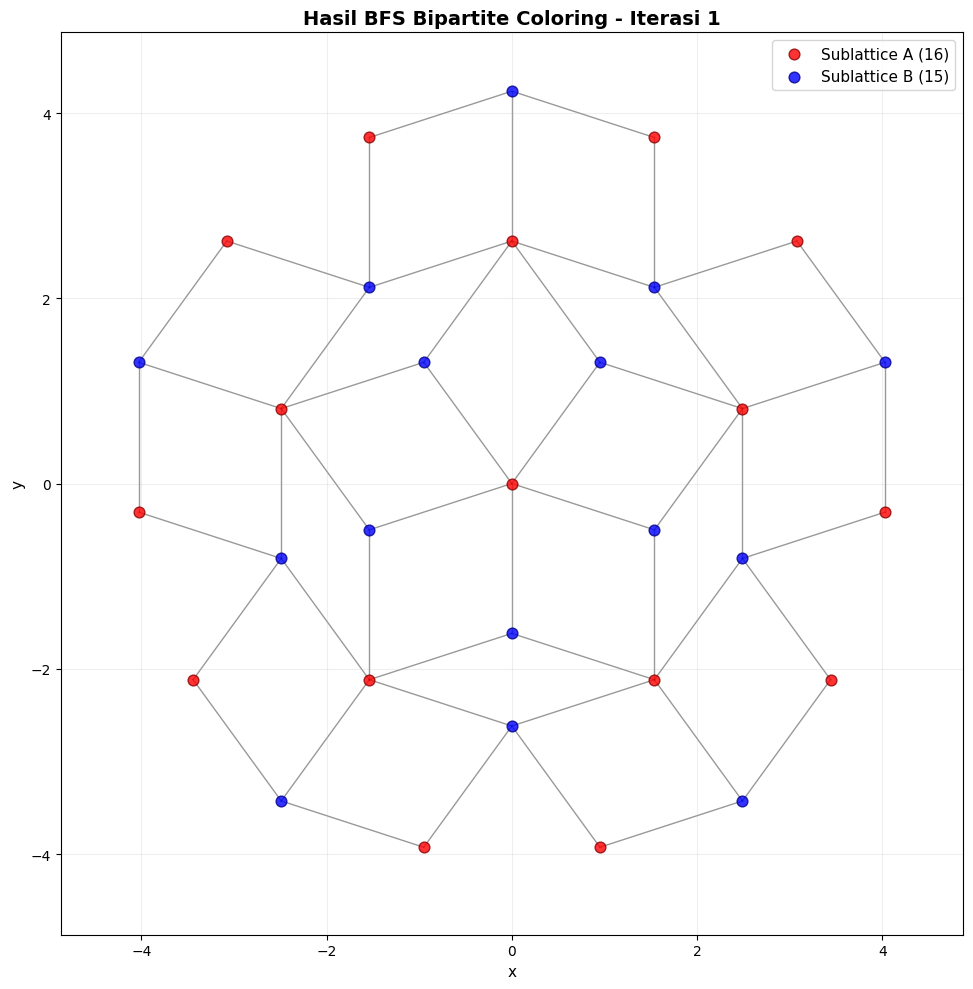

📊 Ringkasan:
   • Sublattice A (merah): 16 vertices
   • Sublattice B (biru): 15 vertices
   • Total: 31 vertices

✅ Graf ini adalah bipartite!
   Semua edge menghubungkan vertex merah ↔ biru


In [14]:
simple_bfs_coloring_demo(iteration=1)